In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import os
from shapely.geometry import Point,  MultiPolygon
import shapely.wkt
import seaborn as sns
!pip install geopy

from geopy.distance import geodesic

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
plt.style.use('ggplot')

In [40]:
#import data sets
schools = pd.read_csv('../Data/ProjectData/act_means.csv')
school_locations = pd.read_csv("../Data/ProjectData/School_Locations.csv")

boundaries_fp='../Data/ProjectData/geo_export.shp'
boundaries=gpd.read_file(boundaries_fp)


In [41]:
schools = schools[schools["Category Breakdown"] == "Overall"]
years_to_keep = [2014, 2015, 2016, 2017]
schools = schools[schools["Year"].isin(years_to_keep)]


columns_to_drop = ['Network', 'Category Breakdown', "Grade","Read", "Means_Math", "Means_Science", "Means_English", "Numbers_Read",	"Numbers_Math",	"Numbers_Science", 	"Numbers_English" ]
schools = schools.drop(columns=columns_to_drop)


In [42]:
school_locations[['Long', 'Lat']] = school_locations['the_geom'].str.extract(r'POINT \(([-\d.]+) ([-\d.]+)\)').astype(float)

schools = schools.rename(columns={'School ID': 'School_ID'})

schools = pd.merge(schools, school_locations, on='School_ID', how='inner')

columns_to_drop2 = ['Short_Name', 'Address', "Grade_Cat"]
schools = schools.drop(columns=columns_to_drop2)

columns_to_check_missing = ['School Name', 'School_ID', 'Category', 'Year']

schools = schools.dropna(subset=columns_to_check_missing)

In [43]:

econ15 = pd.read_csv('../Data/ProjectData/econ15.csv')
econ16 = pd.read_csv("../Data/ProjectData/econ16.csv")
econ17 = pd.read_csv("../Data/ProjectData/econ17.csv")

regions = pd.read_csv("../Data/ProjectData/regions.csv")

In [44]:
precincts = {}
for index, row in regions.iterrows():
  precincts[row['AREA_NUMBE']] = shapely.wkt.loads(row['the_geom'])

pos = 0
prec = np.ndarray((schools.shape[0],))
date = np.ndarray((schools.shape[0],)).astype(str)

for index,row in schools.iterrows():
  
  poo = Point(row['Long'],row['Lat'])  
  for key,val in precincts.items():
    if poo.within(val):
      prec[pos] = key
      break

  pos=pos+1

schools['Precincts'] = prec.astype(int)

schools = schools[schools['Precincts'] >= 0]



In [45]:
precinct_names = {}

for index, row in regions.iterrows():
    precinct_names[row['AREA_NUMBE']] = row['COMMUNITY'] 

# Apply the mapping to the 'Precincts' column in the schools dataframe
schools['Community'] = schools['Precincts'].map(precinct_names)

In [46]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["WHITE","HISP","BLACK","ASIAN","OTHER"]].sum(axis=1)

    demographic_columns = ["WHITE","HISP","BLACK","ASIAN","OTHER"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']

In [47]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["UND19", "A20_34", "A35_49", "A50_64", "A65_79", "OV80"]].sum(axis=1)

    demographic_columns = ["UND19",	"A20_34",	"A35_49",	"A50_64",	"A65_79","OV80"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [48]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["IN_LBFRC", "EMP",	"UNEMP",	"NOT_IN_LBFRC"]].sum(axis=1)

    demographic_columns = ["IN_LBFRC", "EMP",	"UNEMP",	"NOT_IN_LBFRC"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [49]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["INC_LT_25K",	"INC_25_50K",	"INC_50_75K",	"INC_75_100K",	"INC_100_150K",	"INC_GT_150"]].sum(axis=1)

    demographic_columns = ["INC_LT_25K",	"INC_25_50K",	"INC_50_75K",	"INC_75_100K",	"INC_100_150K",	"INC_GT_150"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [50]:
econ15 = econ15.drop(["MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)
econ16 = econ16.drop(["MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)
econ17 = econ17.drop(["MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)

In [51]:
econ15 = econ15.rename(columns={'GEOG': 'Community'})
econ16 = econ16.rename(columns={'GEOG': 'Community'})
econ17 = econ17.rename(columns={'GEOG': 'Community'})

schools['Community'] = schools['Community'].str.lower()
econ15['Community'] = econ15['Community'].str.lower()
econ16['Community'] = econ16['Community'].str.lower()
econ17['Community'] = econ17['Community'].str.lower()

merged_df_15 = pd.merge(schools[schools['Year'] == 2014], econ15, on='Community', how='left')

merged_df_16 = pd.merge(schools[schools['Year'] == 2015], econ16, on='Community', how='left')

merged_df_17 = pd.merge(schools[schools['Year'] == 2016], econ17, on='Community', how='left')

schools = pd.concat([merged_df_15, merged_df_16, merged_df_17], ignore_index=True)


In [53]:
## decision tree, accuracy 0.9 when the target is divided into 100 categories. 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


exclude_columns = ['School Name', 'School_ID', "Category","Year", "Numbers_Composite", "the_geom","Community" ]

target_column = 'Means_Composite'

df = schools.dropna()
X = df.drop(exclude_columns, axis=1)

y = df[target_column]
y = pd.cut(y, bins=100, labels=[f'Bin_{i}' for i in range(1, 101)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8837209302325582


/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [54]:
parks = gpd.read_file("../Data/ProjectData/parks.csv")  ## parks and facilities
libraries = gpd.read_file("../Data/ProjectData/libraries.csv")


In [55]:
columns_to_drop3 = ['OBJECTID_1', "GISOBJID","geometry"]
parks = parks.drop(columns=columns_to_drop3)
parks = parks.rename(columns={'X_COORD': 'Long', 'Y_COORD': 'Lat'})


In [56]:
geometry_schools = [Point(xy) for xy in zip(schools['Long'], schools['Lat'])]
gdf_schools = gpd.GeoDataFrame(schools, geometry=geometry_schools)

# Create GeoDataFrame for parks
geometry_parks = [Point(xy) for xy in zip(parks['Long'], parks['Lat'])]
gdf_parks = gpd.GeoDataFrame(parks, geometry=geometry_parks)

# Buffer schools by 1 km
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.009)  # 1 degree is approximately 111 km

# Find parks within the buffered area of each school
parks_within_2km = gpd.sjoin(buffered_schools, gdf_parks, how='left', op='contains')

parks_count_by_school = parks_within_2km.groupby('School_ID')['PARK_NO'].count().reset_index()

schools = pd.merge(schools, parks_count_by_school, on='School_ID', how='left')  # facilities in parks

/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [57]:
libraries[['Lat', 'Long']] = libraries['LOCATION'].str.extract(r'\(([^,]+),\s*([^)]+)\)')

libraries = libraries.drop(columns = "geometry")

In [58]:
geometry_schools = [Point(xy) for xy in zip(schools['Long'], schools['Lat'])]
gdf_schools = gpd.GeoDataFrame(schools, geometry=geometry_schools)

geometry_libraries = [Point(xy) for xy in zip(libraries['Long'], libraries['Lat'])]
gdf_libraries = gpd.GeoDataFrame(libraries, geometry=geometry_libraries)

# Buffer schools by 1 km
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.009)  # 1 degree is approximately 111 km

# Find parks within the buffered area of each school
libraries_within_2km = gpd.sjoin(buffered_schools, gdf_libraries, how='left', op='contains')

# Count the number of parks within 2 km for each school
libraries_count_by_school = libraries_within_2km.groupby('School_ID')['NAME'].count().reset_index()

schools = pd.merge(schools, libraries_count_by_school, on='School_ID', how='left')  # libraries in 2 km

/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [59]:
schools = schools.rename(columns={'PARK_NO': 'Num_parkfacility','NAME': 'Num_lib' })

In [60]:
crimes = pd.read_csv("../Data/ProjectData/Crimes2014_2020.csv")

In [61]:
crimes = crimes[['Date', 'Block', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Location']]

In [62]:
types = "ARSON", "HOMICIDE", "OFFENSE INVOLVING CHILDREN","ROBBERY"
crimes = crimes[crimes["Primary Type"].isin(types)]

crimes = crimes.rename(columns={'Latitude': 'Lat', "Longitude": "Long"})

crimes = crimes.dropna(subset=["Year", "Lat", "Long"])

In [63]:
geometry_crimes = [Point(xy) for xy in zip(crimes['Long'], crimes['Lat'])]
gdf_crimes = gpd.GeoDataFrame(crimes, geometry=geometry_crimes)

# Buffer schools by 2 km
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.018)  # 1 degree is approximately 111 km

robbery_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'ROBBERY'][['geometry', 'Year']],
    how='left',
    op='contains'
)

robbery_count_by_school_year = (
    robbery_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Robbery_Count'})
)

robbery_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)


schools = pd.merge(schools, robbery_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [65]:
arson_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'ARSON'][['geometry', 'Year']],
    how='left',
    op='contains'
)

arson_count_by_school_year = (
    arson_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Arson_Count'})
)

arson_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)


schools = pd.merge(schools, arson_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [66]:
homicide_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'HOMICIDE'][['geometry', 'Year']],
    how='left',
    op='contains'
)

homicide_count_by_school_year = (
    homicide_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Homicide_Count'})
)

homicide_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)


schools = pd.merge(schools, homicide_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [67]:
offense_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'OFFENSE INVOLVING CHILDREN'][['geometry', 'Year']],
    how='left',
    op='contains'
)

offense_count_by_school_year = (
    offense_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Offense_Count'})
)

offense_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)


schools = pd.merge(schools, offense_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [96]:
schools

,School Name,School_ID,Category,Year,Means_Composite,Numbers_Composite,the_geom,Lat,Long,Precincts,Community,WHITE,HISP,BLACK,ASIAN,OTHER,UND19,A20_34,A35_49,A50_64,A65_79,OV80,IN_LBFRC,EMP,UNEMP,NOT_IN_LBFRC,INC_LT_25K,INC_25_50K,INC_50_75K,INC_75_100K,INC_100_150K,INC_GT_150,Num_parkfacility,Num_lib,Robbery_Count,Arson_Count,Homicide_Count,Offense_Count
0,AIR FORCE HS,610513.0,Overall,2014.0,18.5,101,POINT (-87.63275698311773 41.82814532285343),41.828145,-87.632757,34,armour square,0.114560,0.036470,0.117805,0.695189,0.035976,0.208451,0.217269,0.195260,0.200973,0.103837,0.074210,0.385714,0.324860,0.060853,0.228573,0.510013,0.179859,0.146672,0.077437,0.057791,0.028228,72,3,672.0,30.0,21.0,75
1,ALCOTT HS,610524.0,Overall,2014.0,17.7,50,POINT (-87.68056201257482 41.93579455641457),41.935795,-87.680562,5,north center,0.774744,0.143684,0.018504,0.036775,0.026293,0.194938,0.349482,0.252563,0.128598,0.056061,0.018359,0.445844,0.421651,0.023881,0.108624,0.106497,0.153516,0.175620,0.124849,0.181648,0.257870,72,0,213.0,15.0,3.0,69
2,AMUNDSEN HS,609695.0,Overall,2014.0,17.0,263,POINT (-87.67948421494016 41.97506725668829),41.975067,-87.679484,4,lincoln square,0.645227,0.163783,0.046370,0.116715,0.027905,0.166343,0.327644,0.234489,0.171309,0.078827,0.021388,0.434489,0.398753,0.035275,0.131483,0.196083,0.220140,0.183969,0.126288,0.134496,0.139024,36,0,150.0,3.0,6.0,60
3,ASPIRA - EARLY COLLEGE HS,400013.0,Overall,2014.0,15.3,99,POINT (-87.72709565848761 41.93729828527434),41.937298,-87.727096,21,avondale,0.290572,0.636804,0.019721,0.031494,0.021410,0.255253,0.315633,0.212210,0.138667,0.062168,0.016070,0.410416,0.371232,0.039184,0.179168,0.241482,0.331436,0.185453,0.095499,0.092945,0.053185,75,0,375.0,42.0,21.0,180
4,BOGAN HS,609698.0,Overall,2014.0,15.6,306,POINT (-87.72109744629034 41.749375610128205),41.749376,-87.721097,70,ashburn,0.159128,0.343266,0.489012,0.003643,0.004951,0.300413,0.196819,0.208776,0.198898,0.066533,0.028561,0.396720,0.346664,0.050056,0.206560,0.170890,0.198955,0.193420,0.166446,0.193966,0.076323,66,3,132.0,12.0,9.0,54
5,BOWEN HS,610323.0,Overall,2014.0,14.8,81,POINT (-87.55755003384358 41.734626720502284),41.734627,-87.557550,46,south chicago,0.028810,0.226146,0.733443,0.004578,0.007022,0.303146,0.207111,0.184875,0.166047,0.107256,0.031564,0.357446,0.277745,0.079701,0.285108,0.443676,0.282615,0.126007,0.074088,0.045571,0.028044,87,3,540.0,24.0,45.0,201
6,BRONZEVILLE HS,610381.0,Overall,2014.0,16.4,118,POINT (-87.62500446841632 41.80520417115968),41.805204,-87.625004,38,grand boulevard,0.042750,0.028187,0.904896,0.004467,0.019700,0.283883,0.195926,0.230323,0.159787,0.098678,0.031404,0.384194,0.285044,0.097906,0.232856,0.445210,0.200405,0.141916,0.090218,0.068424,0.053827,69,3,972.0,15.0,33.0,219
7,BROOKS HS,609726.0,Overall,2014.0,23.1,176,POINT (-87.61635260656355 41.692762529207194),41.692763,-87.616353,49,roseland,0.011350,0.010968,0.963097,0.003394,0.011192,0.283762,0.170851,0.179998,0.201483,0.123564,0.040342,0.343090,0.261426,0.080341,0.315142,0.338912,0.285914,0.191207,0.085674,0.074915,0.023378,99,3,696.0,30.0,33.0,159
8,CAMELOT - CHICAGO EXCEL HS,400147.0,Overall,2014.0,13.8,78,POINT (-87.65372653786373 41.69196931444993),41.691969,-87.653727,75,morgan park,0.329630,0.019759,0.628731,0.004367,0.017512,0.265604,0.185550,0.185253,0.208234,0.098965,0.056394,0.383776,0.329018,0.054458,0.232748,0.196645,0.210915,0.168231,0.144574,0.171611,0.108024,81,0,375.0,9.0,27.0,93
9,CAMELOT - EXCEL ENGLEWOOD HS,610565.0,Overall,2014.0,13.5,47,POINT (-87.64912434694986 41.76389597409202),41.763896,-87.649124,68,englewood,0.006629,0.010860,0.967032,0.000776,0.014703,0.331829,0.218892,0.160220,0.175064,0.079828,0.034167,0.329346,0.212349,0.115388,0.342917,0.602963,0.210128,0.115255,0.037718,0.023429,0.010506,0,3,1461.0,63.0,90.0,252


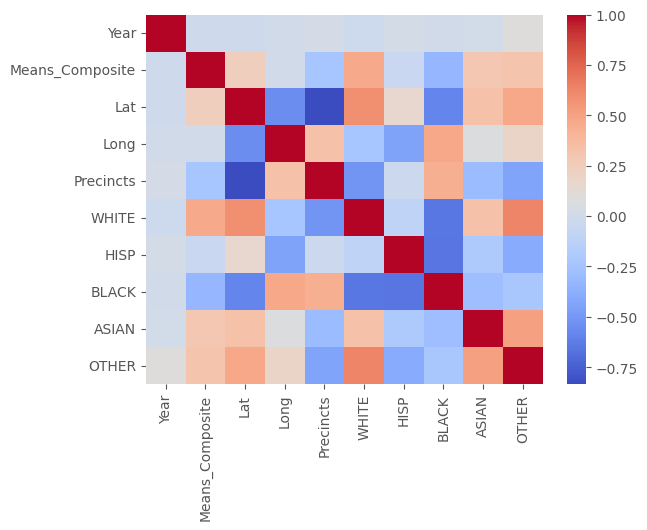

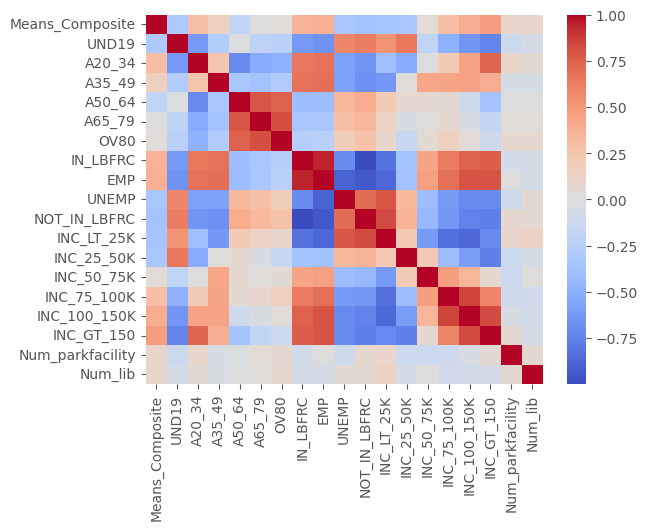

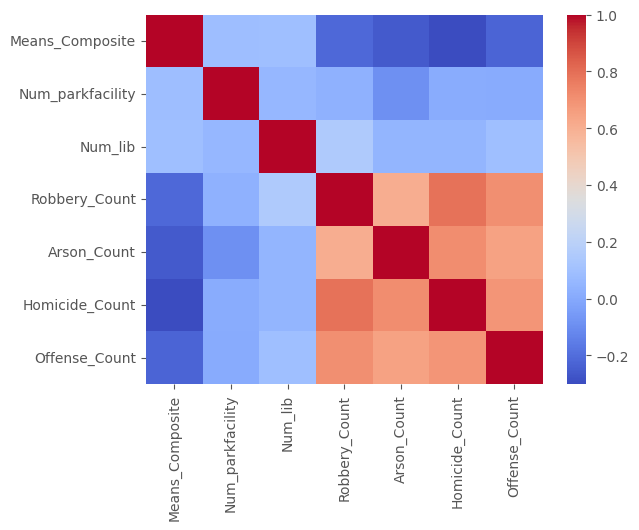

In [68]:
numeric_df = schools.select_dtypes(include='number')  # Select only numeric columns

numeric_df1= numeric_df[["Year",'Means_Composite', 'Lat', 'Long', 'Precincts',
        'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']]

correlation_matrix1 = numeric_df1.corr()

# Generate a heatmap without numbers
sns.heatmap(correlation_matrix1, cmap='coolwarm', annot=False)
plt.show()

numeric_df2= numeric_df[[ 'Means_Composite','UND19',
       'A20_34', 'A35_49', 'A50_64', 'A65_79', 'OV80', 'IN_LBFRC', 'EMP',
       'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K', 'INC_25_50K', 'INC_50_75K',
       'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'Num_parkfacility',
       'Num_lib']]

correlation_matrix2 = numeric_df2.corr()

# Generate a heatmap without numbers
sns.heatmap(correlation_matrix2, cmap='coolwarm', annot=False)
plt.show()

numeric_df3= numeric_df[['Means_Composite',"Num_parkfacility", "Num_lib","Robbery_Count", "Arson_Count", "Homicide_Count",
                         "Offense_Count"]]

correlation_matrix3 = numeric_df3.corr()

sns.heatmap(correlation_matrix3, cmap='coolwarm', annot=False)
plt.show()

In [70]:
## Hyperedges
# 1- DBSCAN for Crime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [98]:
crimes_arson = crimes[crimes["Primary Type"] == "ARSON"]

crimes_arson_2014 = crimes_arson[crimes_arson["Year"] == 2014]
crimes_arson_2015 = crimes_arson[crimes_arson["Year"] == 2015]
crimes_arson_2016 = crimes_arson[crimes_arson["Year"] == 2016]

def DBSCAN_func(df):
    
    features = df[['Lat', 'Long']]
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    eps = 0.3
    min_samples = 20
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(features_scaled)
    
    # Add cluster information back to the original DataFrame
    df['Cluster'] = clusters
        
    return df
    
print(DBSCAN_func(crimes_arson_2014))

                     Date                      Block Primary Type  \
78551 2014-12-31 05:55:00         045XX S ALBANY AVE        ARSON   
78561 2014-12-30 18:48:00           090XX S LOWE AVE        ARSON   
78579 2014-12-30 04:49:00          046XX N MARINE DR        ARSON   
78615 2014-12-29 02:45:00            021XX W 51ST PL        ARSON   
78688 2014-12-27 00:48:00      028XX S SPAULDING AVE        ARSON   
78700 2014-12-26 20:45:00        026XX N WESTERN AVE        ARSON   
78899 2014-12-21 20:20:00        093XX S LA SALLE ST        ARSON   
78946 2014-12-20 20:00:00          028XX S TRIPP AVE        ARSON   
79016 2014-12-19 10:44:00       051XX W WEST END AVE        ARSON   
79033 2014-12-19 00:58:00      040XX S LAKE PARK AVE        ARSON   
79075 2014-12-17 19:00:00            023XX W 18TH PL        ARSON   
79107 2014-12-17 02:30:00          076XX S PERRY AVE        ARSON   
79246 2014-12-13 15:00:00          047XX W MONROE ST        ARSON   
79262 2014-12-13 04:55:00         

/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/siji/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future ver